In [1]:
import numpy as np
import tables
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import phd
from phd.satellite.mean_table import MeanItem
from phd.satellite.single_processing import DataMeshLoader, calculate_interpolators, \
    LikelihoodFactory, DetectorCharacter, load_likelihood_factory
from scipy.optimize import minimize
import importlib

In [39]:

importlib.reload(MeanItem)

TypeError: reload() argument must be a module

# Есть ли пик Брэгга

In [1]:

path = "/home/zelenyy/data/satellite/mean_mesh.hdf5"

In [2]:
dataLoaderProton = DataMeshLoader(path, particle="proton")

NameError: name 'DataMeshLoader' is not defined

In [5]:
path = "/mnt/storage2/phd/data/satellite/polistyrene/proton.hdf5"
with tables.open_file(path) as h5file:
    data = h5file.get_node("/", "deposit").read()


In [11]:
def is_non_zero(event: np.ndarray):
    return np.all(event == 0)

def prepare_event(event: np.ndarray, treshold_scale = 10):
    mean = event.mean()
    indx = event < (mean/treshold_scale)
    event[indx] = 0.0
    return event

def get_last_cell(event: np.ndarray):
    i = np.argmin(event != 0)
    
    
def calc_bregg_ration(event: np.ndarray, treshold_scale = 10):
    if np.all(event == 0):
        return 0.0
    i = np.argmin(event != 0)
    mean = event[:i].mean()
    indx = event < (mean/treshold_scale)
    event[indx] = 0.0
    return event[i-1]/mean


In [12]:
n = data.shape[0]
breg_ratio = np.zeros(n)
for indx, event in enumerate(data["mean"]):
    breg_ratio[indx] = calc_bregg_ration(event, treshold_scale=100)

/home/zelenyy/miniconda3/envs/phd-code/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice.
/home/zelenyy/miniconda3/envs/phd-code/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zelenyy/miniconda3/envs/phd-code/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less


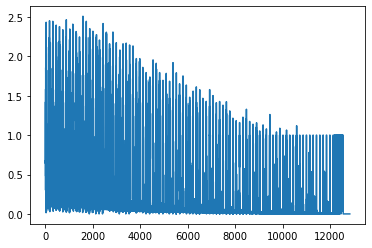

In [14]:
plt.plot(breg_ratio[:141*91])

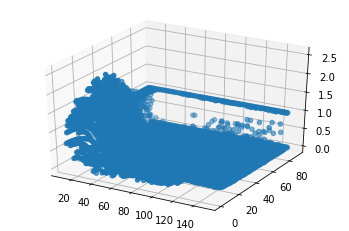

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
n = data.shape[0] // 16
xs = data["energy"][:n]
ys = data["theta"][:n]
zs = breg_ratio[:n]
ax.scatter(xs, ys, zs)

In [19]:
np.sum(breg_ratio>1)/data.shape[0]



/home/zelenyy/miniconda3/envs/phd-code/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


0.08589061647572285

In [19]:
def convert_from_mesh(mesh):
    shape = mesh.shape
    m = shape[1]*shape[2]*shape[3]
    n = shape[0]
    result = np.zeros((m,n))
    for i in range(shape[3]):
        for j in range(shape[2]):
            for k in range(shape[1]):
                indx = k + j*shape[1] + i*shape[1]*shape[2]
                result[indx, :] = mesh[:, k, j, i]
    return result

In [20]:
path = "/home/zelenyy/mean_mesh.hdf5"
dataLoaderElectron = DataMeshLoader(path, particle="electron")
dataLoaderProton = DataMeshLoader(path, particle="proton")

In [21]:
def energy_range(event: np.ndarray):
    if np.all(event ==0):
        return 0.0, 0.0
    ef = np.sum(event)
    r = np.argmin(event!=0) + 1
    return ef, r




In [22]:
def er_ration(mesh):
    mean = convert_from_mesh(mesh)
    full_energy = np.zeros(mean.shape[0])
    full_range = np.zeros(mean.shape[0])
    for indx, event in enumerate(mean):
        ef, r = energy_range(event)
        full_range[indx] = r
        full_energy[indx] = ef
    return full_energy, full_range
    
    

In [28]:
electron_full_energy, electron_range = er_ration(dataLoaderElectron.mean)

In [24]:
proton_energy, proton_range = er_ration(dataLoaderProton.mean)

In [32]:
electron_energy = dataLoaderElectron.energy_normilizer.unnormalize(dataLoaderElectron.energy)
nk = dataLoaderElectron.theta.size*dataLoaderElectron.shift.size
electron_energy = np.tile(electron_energy, nk)

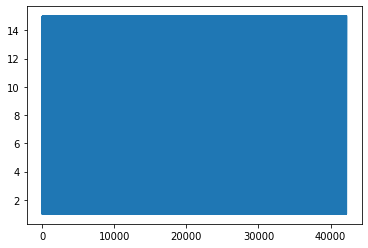

In [33]:
plt.plot(electron_energy)

In [34]:
miss = np.abs(electron_full_energy - electron_energy)/electron_energy

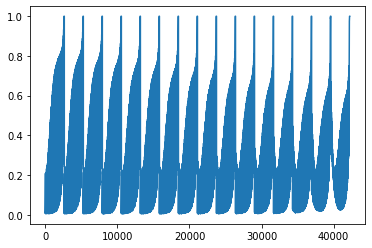

In [35]:
plt.plot(miss)

In [45]:
indx = np.logical_and(theta<30, shift<0.5)

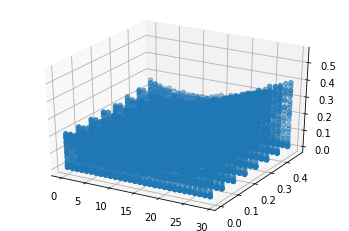

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xs = theta[indx]
ys = shift[indx]
zs = miss[indx]
ax.scatter(xs, ys, zs)

In [ ]:
mesh_miss = miss.reshape((dataLoaderElectron.theta.size, dataLoaderElectron.shift.size))

In [17]:
proton_er_ratio = proton_energy/proton_range
electron_er_ratio = electron_energy/electron_range

/home/zelenyy/miniconda3/envs/phd-code/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/zelenyy/miniconda3/envs/phd-code/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


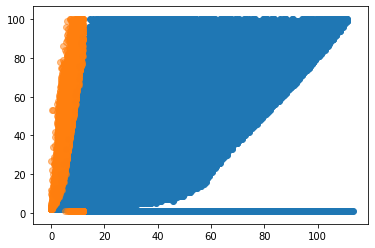

In [18]:
indx_e = electron_energy!=0
indx_p = proton_energy!=0
plt.scatter(proton_energy[indx_p], proton_range[indx_p])
plt.scatter(electron_energy[indx_e], electron_range[indx_e], alpha=0.5)

In [ ]:
plt.plot(proton_er_ratio[proton_er_ratio!=0])
plt.plot(electron_er_ratio[electron_er_ratio !=0])





In [21]:

np.rad2deg(np.arctan(3.0/8.0))

20.556045219583467

In [13]:
np.rad2deg(np.arctan(10.0/14.0))

35.53767779197438

In [14]:
46*200

9200

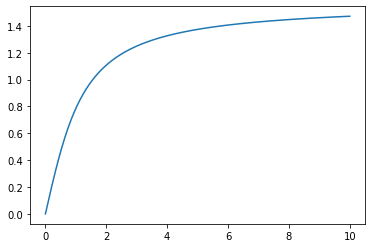

In [20]:
x = np.linspace(0, 10, 300)
plt.plot(x, np.arctan(x))
